In [65]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from prophet import Prophet
import xlrd
import re

In [2]:
df = pd.read_excel('superstore.xls')

In [3]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [4]:
furniture = df.loc[df['Category']== 'Furniture']  # Select only furnitures from category

In [5]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [6]:
# Select only order Date and sales column
# Drop all these below features
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name','Quantity', 'Discount', 'Profit']

In [7]:
furniture.drop(cols, axis=1, inplace=True)

In [8]:
furniture

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
...,...,...
9962,2015-03-19,383.4656
9964,2016-12-05,13.4000
9980,2015-09-06,85.9800
9989,2014-01-21,25.2480


In [9]:
furniture = furniture.sort_values('Order Date')

In [10]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [11]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [12]:
furniture = furniture.groupby('Order Date')

In [13]:
furniture = furniture['Sales'].sum().reset_index()
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


In [14]:
furniture = furniture.set_index('Order Date')
furniture

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
...,...
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568


In [15]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [16]:
y = furniture['Sales'].resample('MS').mean() # consider only starting of every month

In [17]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

In [18]:
import matplotlib.pyplot as plt

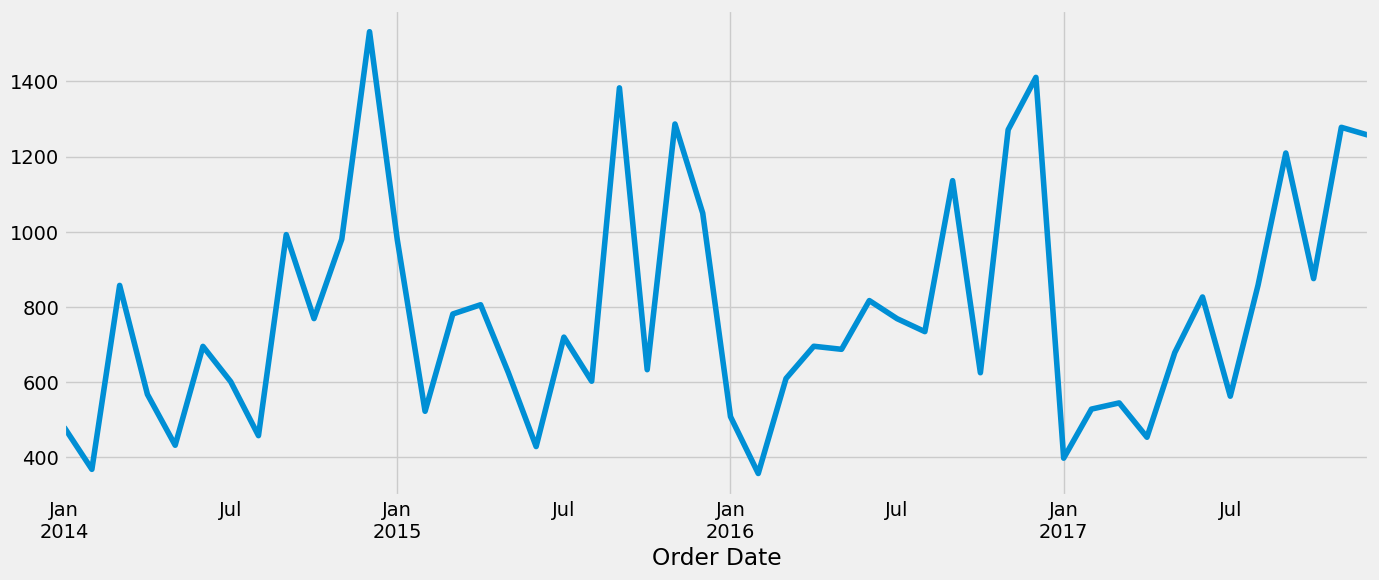

In [19]:
y.plot(figsize=(15,6))
plt.show()

In [20]:
from pylab import rcParams

In [21]:
rcParams['figure.figsize'] = 18,8

In [22]:
import statsmodels.api as sm

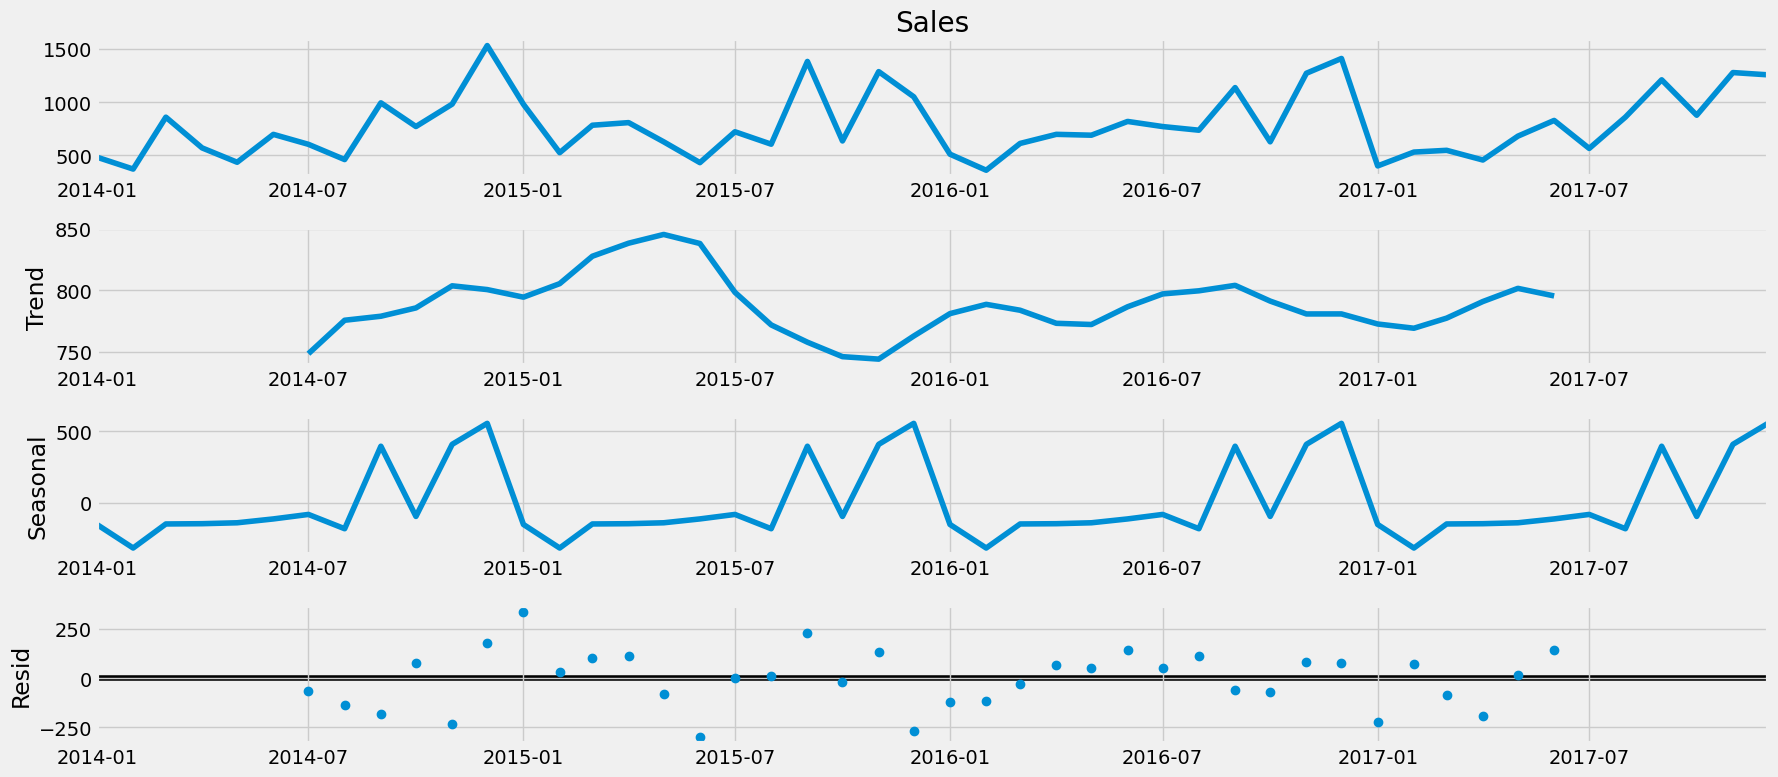

In [23]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#  Time Series Forecasting with ARIMA

In [24]:
import itertools

In [25]:
p = d = q = range(0,2)

In [26]:
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [27]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [28]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [29]:
print("Examples of parameter combination for seasonal ARIMA")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combination for seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [30]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
            order=param,
            seasonal_order = param_seasonal,
            enforce_stationary=False,
            enforce_invertibility=False)
            
            results=mod.fit()
            print("ARIMA{}x{}12-AIC:{}".format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC:784.7193402038779
ARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC:2077.6262393156576
ARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC:495.37090274829427
ARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC:489.83053264640563
ARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC:691.7786646587501
ARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC:1875.4622560491086
ARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC:491.2539819426636
ARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC:491.8095630494035
ARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC:751.0635462762982


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC:2041.3417206237732
ARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC:497.0445558719425
ARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC:491.6640771286905
ARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC:689.6572888616004


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC:1717.285028245164
ARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC:493.19798657859207
ARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC:493.6293522353135
ARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC:691.6686053842182


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC:1939.3857565415747
ARIMA(0, 1, 0)x(0, 1, 0, 12)12-AIC:501.19171493471
ARIMA(0, 1, 0)x(0, 1, 1, 12)12-AIC:498.22118357481725
ARIMA(0, 1, 0)x(1, 0, 0, 12)12-AIC:672.7905898082892


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12-AIC:2059.308220908635
ARIMA(0, 1, 0)x(1, 1, 0, 12)12-AIC:500.1070474247856
ARIMA(0, 1, 0)x(1, 1, 1, 12)12-AIC:500.0205212319823
ARIMA(0, 1, 1)x(0, 0, 0, 12)12-AIC:679.3515257502529


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12-AIC:1718.533732060723
ARIMA(0, 1, 1)x(0, 1, 0, 12)12-AIC:489.6345113973407
ARIMA(0, 1, 1)x(0, 1, 1, 12)12-AIC:482.8319527901415
ARIMA(0, 1, 1)x(1, 0, 0, 12)12-AIC:656.5174592655308
ARIMA(0, 1, 1)x(1, 0, 1, 12)12-AIC:1671.2128604747095
ARIMA(0, 1, 1)x(1, 1, 0, 12)12-AIC:484.71167476994793
ARIMA(0, 1, 1)x(1, 1, 1, 12)12-AIC:484.8279025406241
ARIMA(1, 0, 0)x(0, 0, 0, 12)12-AIC:707.8812143770797


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12-AIC:1629.5798848669178
ARIMA(1, 0, 0)x(0, 1, 0, 12)12-AIC:496.96369022311274
ARIMA(1, 0, 0)x(0, 1, 1, 12)12-AIC:491.6434591679852
ARIMA(1, 0, 0)x(1, 0, 0, 12)12-AIC:682.5313940470356


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12-AIC:1998.0427480868998
ARIMA(1, 0, 0)x(1, 1, 0, 12)12-AIC:493.1879623942238
ARIMA(1, 0, 0)x(1, 1, 1, 12)12-AIC:493.60743074343696
ARIMA(1, 0, 1)x(0, 0, 0, 12)12-AIC:697.3491224677175


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12-AIC:2100.5982657941777
ARIMA(1, 0, 1)x(0, 1, 0, 12)12-AIC:498.8527554530435
ARIMA(1, 0, 1)x(0, 1, 1, 12)12-AIC:493.5574635101766
ARIMA(1, 0, 1)x(1, 0, 0, 12)12-AIC:673.3007603838051


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12-AIC:1685.3945717751071
ARIMA(1, 0, 1)x(1, 1, 0, 12)12-AIC:495.0826671361597
ARIMA(1, 0, 1)x(1, 1, 1, 12)12-AIC:495.32390541589524
ARIMA(1, 1, 0)x(0, 0, 0, 12)12-AIC:684.9765838986987


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12-AIC:1847.906022215896
ARIMA(1, 1, 0)x(0, 1, 0, 12)12-AIC:494.3112171937178
ARIMA(1, 1, 0)x(0, 1, 1, 12)12-AIC:490.6242752112444
ARIMA(1, 1, 0)x(1, 0, 0, 12)12-AIC:665.2664123034721


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12-AIC:1585.6211739188955
ARIMA(1, 1, 0)x(1, 1, 0, 12)12-AIC:491.85420116840424
ARIMA(1, 1, 0)x(1, 1, 1, 12)12-AIC:492.5754415767489
ARIMA(1, 1, 1)x(0, 0, 0, 12)12-AIC:678.4136280158773


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12-AIC:2070.793336861281
ARIMA(1, 1, 1)x(0, 1, 0, 12)12-AIC:490.8791080244476
ARIMA(1, 1, 1)x(0, 1, 1, 12)12-AIC:484.59366780433584
ARIMA(1, 1, 1)x(1, 0, 0, 12)12-AIC:656.5344048752127


c:\users\mahes\desktop\x training\time_series2\time_series\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12-AIC:2123.47313958534
ARIMA(1, 1, 1)x(1, 1, 0, 12)12-AIC:486.5631981200088
ARIMA(1, 1, 1)x(1, 1, 1, 12)12-AIC:486.5821503896621


In [31]:
model = sm.tsa.statespace.SARIMAX(y,
                                order = (0, 1, 1),
                                seasonal_order = (0, 1, 1, 12),
                                enforce_stationary=False,
                                enforce_invertibility=False)
results=model.fit()
print(results.summary().tables[1])     # one of the diagonostics

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1061.167     -0.001      0.999   -2080.848    2078.848
ma.S.L12      -1.0001   1061.232     -0.001      0.999   -2080.977    2078.976
sigma2      2.686e+04      0.002   1.53e+07      0.000    2.69e+04    2.69e+04


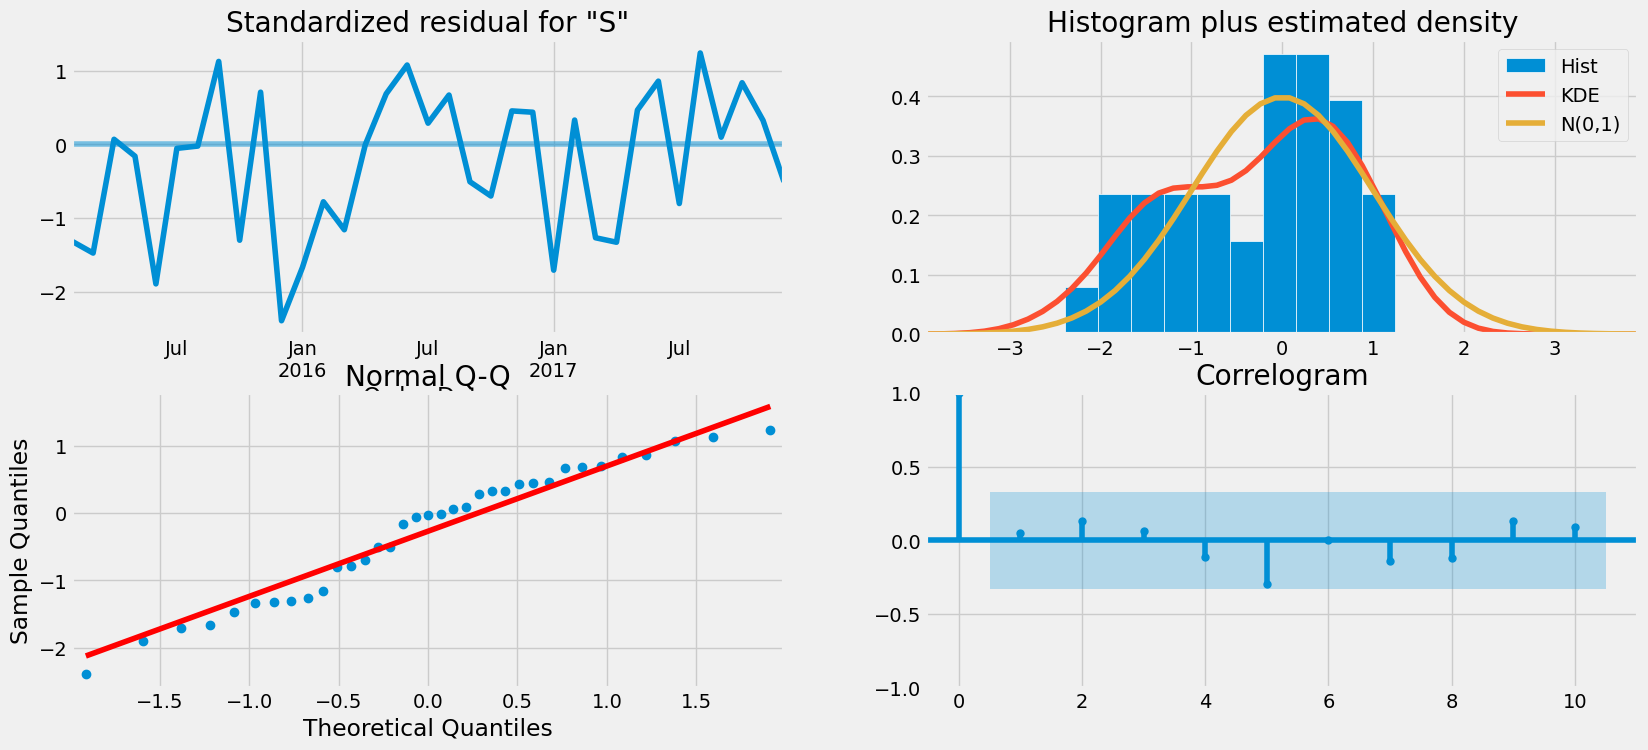

In [32]:
results.plot_diagnostics(figsize=(18,8))
plt.show()

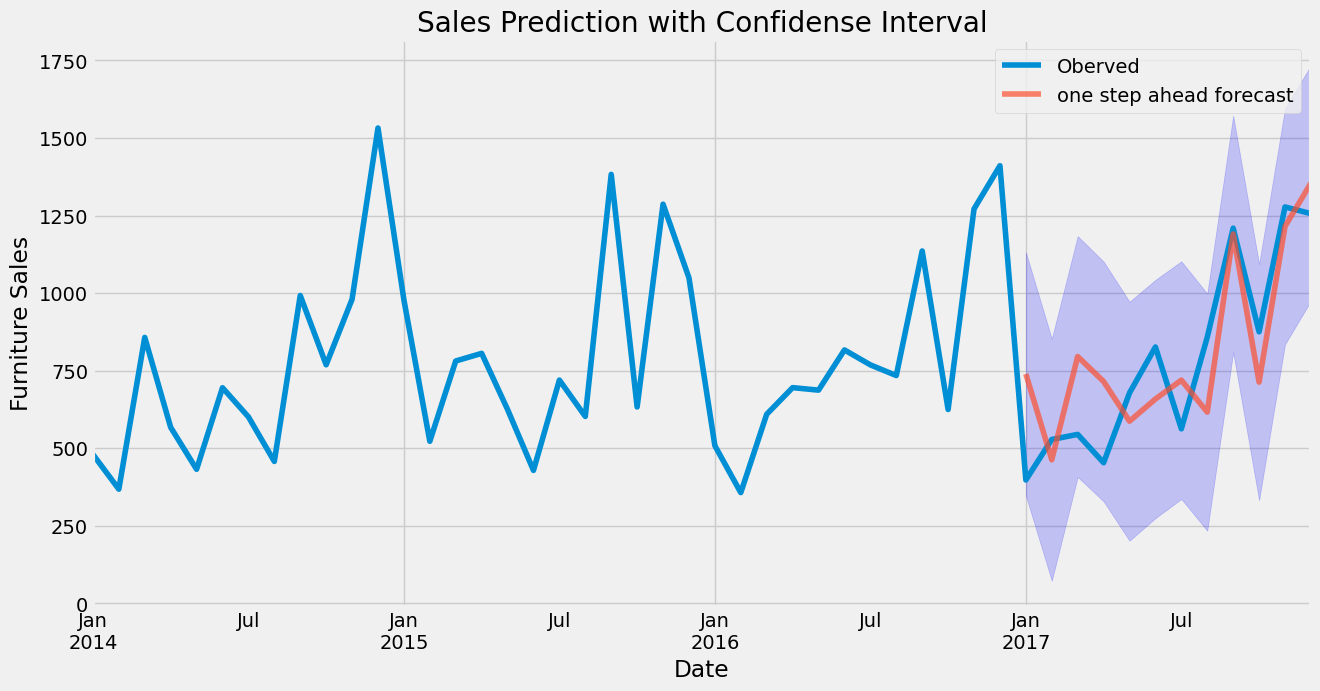

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='Oberved')
pred.predicted_mean.plot(ax=ax, label='one step ahead forecast', alpha=0.7, figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                alpha=0.2,color='b')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.savefig('one_step_forecast.png')
plt.title("Sales Prediction with Confidense Interval")
plt.show()

In [34]:
pred_ci

,lower Sales,upper Sales
Order Date,,
2017-01-01,346.956910,1131.839452
2017-02-01,72.635337,852.882082
2017-03-01,407.490473,1183.861496
2017-04-01,328.638282,1101.817184
2017-05-01,201.898417,972.405279
2017-06-01,274.530051,1042.767468
2017-07-01,336.391369,1102.677302
2017-08-01,234.085018,998.674964
2017-09-01,809.153950,1572.256317


In [35]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted-y_truth) ** 2).mean()
print("The Mean Squared Error of the forecast is {}".format(round(mse, 2)))

The Mean Squared Error of the forecast is 34370.12


In [36]:
import numpy as np

In [37]:
print("the Root Mean Squared Error of the forecast is {}".format(round(np.sqrt(mse),2)))

the Root Mean Squared Error of the forecast is 185.39


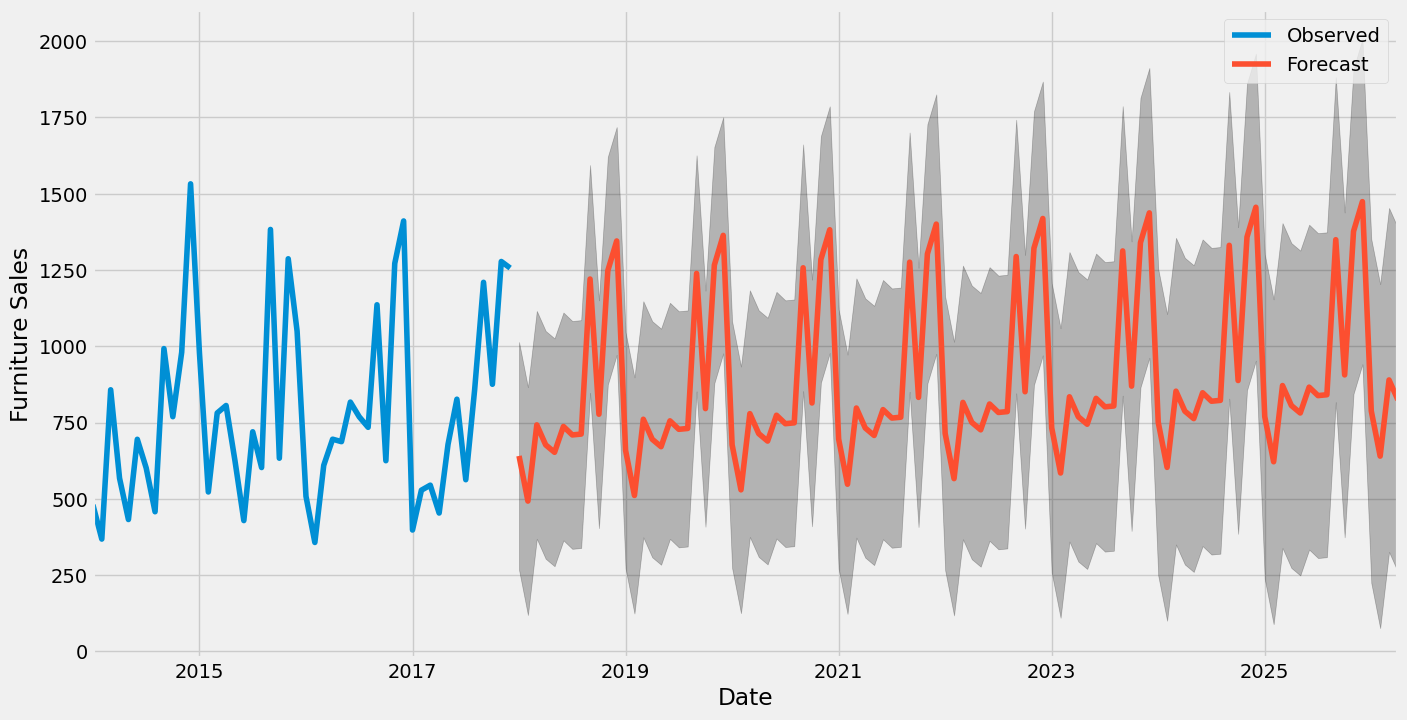

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(15,8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:,0],
                    pred_ci.iloc[:,1],
                    color='k', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [39]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category']=='Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [40]:
cols= ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
        'Customer Name', 'Segment', 'Country', 'City', 'State', 
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
       'Product Name', 'Quantity', 'Discount', 'Profit']

In [41]:
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [42]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [43]:
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [44]:
office.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430


In [45]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_furniture

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

In [46]:
y_office = office['Sales'].resample('MS').mean()
y_office

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504188
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

In [47]:
furniture= pd.DataFrame({"Order Date": y_furniture.index, "Sales":y_furniture.values})
furniture.head()

,Order Date,Sales
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


In [48]:
office = pd.DataFrame({"Order Date": y_office.index, "Sales": y_office.values})
office.head()

,Order Date,Sales
0,2014-01-01,285.357647
1,2014-02-01,63.042588
2,2014-03-01,391.176318
3,2014-04-01,464.794750
4,2014-05-01,324.346545


In [49]:
store = furniture.merge(office, on='Order Date', how='inner')
store.head()

,Order Date,Sales_x,Sales_y
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [50]:
store.rename(columns={'Sales_x': 'Furniture_sales', 'Sales_y': 'Office_sales'}, inplace=True)
store.head()

,Order Date,Furniture_sales,Office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


<function matplotlib.pyplot.show(close=None, block=None)>

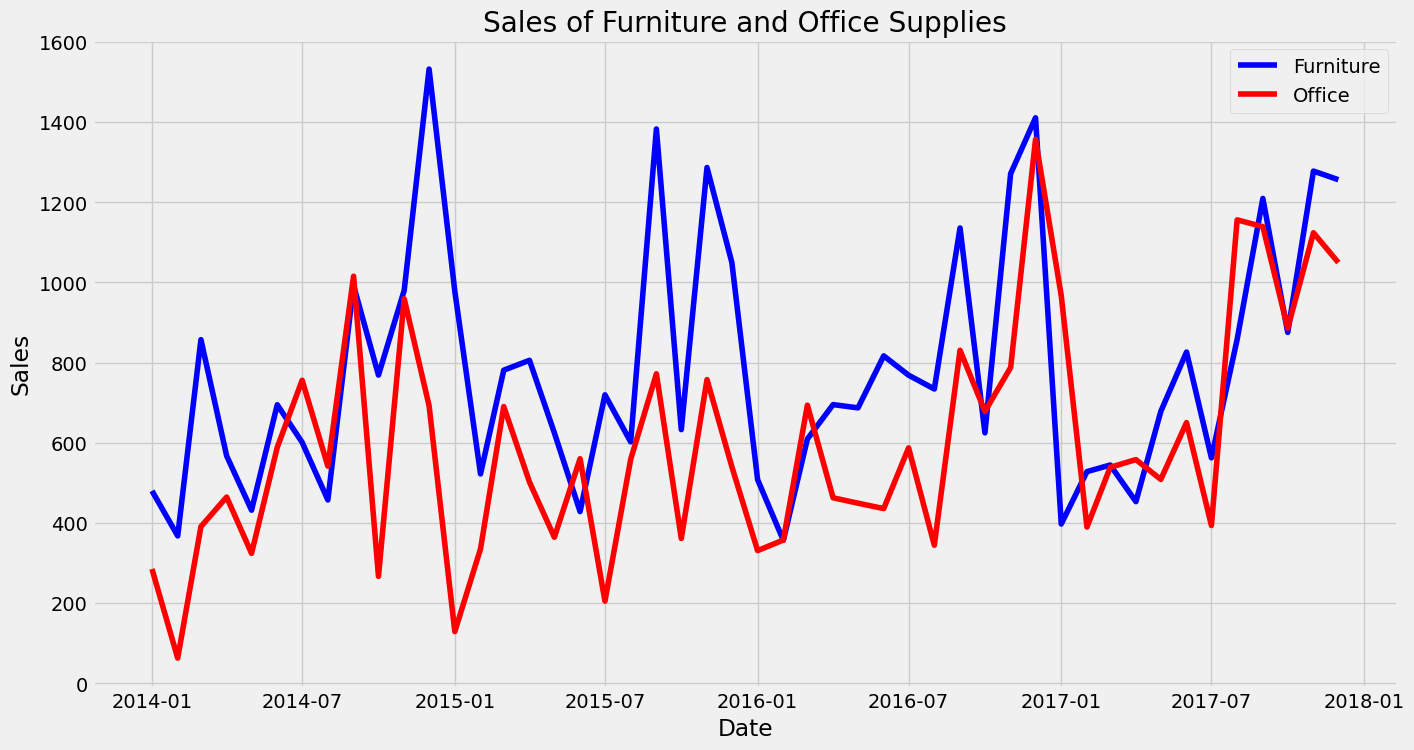

In [51]:
### Plot the figure

plt.figure(figsize=(15,8))
plt.plot(store['Order Date'], store['Furniture_sales'], 'b-', label='Furniture')
plt.plot(store['Order Date'], store['Office_sales'], 'r-', label='Office')
plt.xlabel('Date'),
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend()
plt.show

In [52]:
first_date = store.loc[np.min(list(np.where(store['Office_sales']>store['Furniture_sales'])[0])), 'Order Date']
first_date

Timestamp('2014-07-01 00:00:00')

In [53]:
# first date where office sales crossed furniture sales
print(r"First date where office sales crossed furniture sales: {}".format(first_date.date()))

First date where office sales crossed furniture sales: 2014-07-01


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


<Figure size 1800x600 with 0 Axes>

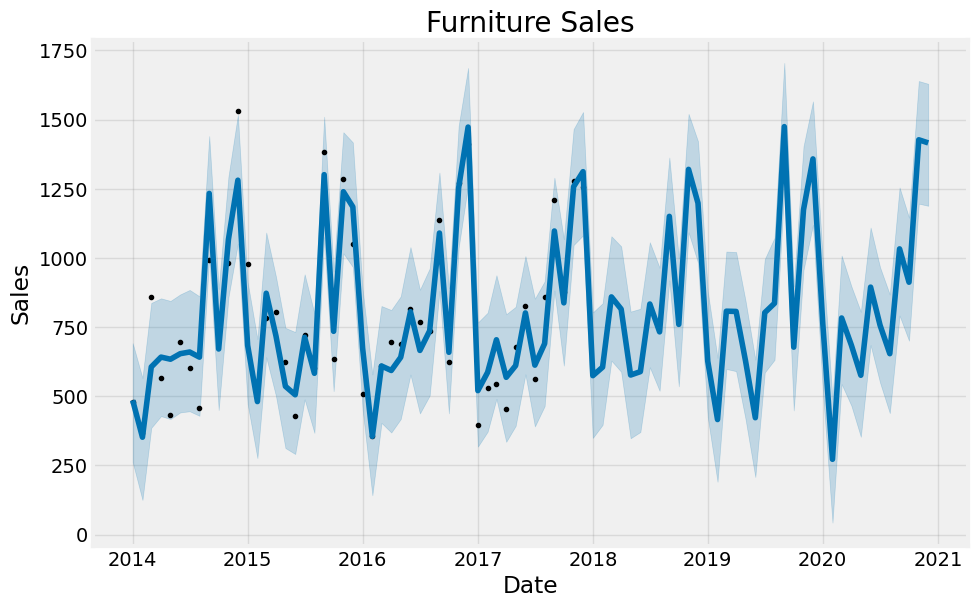

In [54]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

Text(0.5, 1.0, 'Office Supplies Forecast')

<Figure size 1800x600 with 0 Axes>

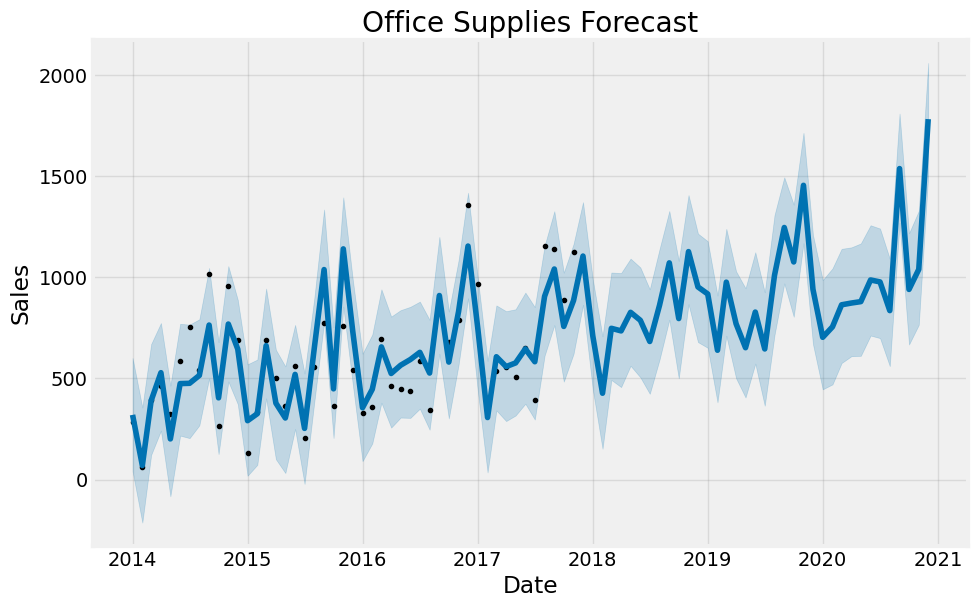

In [55]:
plt.figure(figsize=(18,6))
office_model.plot(office_forecast, xlabel='Date', ylabel= 'Sales')
plt.title('Office Supplies Forecast')

In [56]:
furniture_names = ['furniture_%s' %column for column in furniture_forecast.columns]
furniture_names

['furniture_ds',
 'furniture_trend',
 'furniture_yhat_lower',
 'furniture_yhat_upper',
 'furniture_trend_lower',
 'furniture_trend_upper',
 'furniture_additive_terms',
 'furniture_additive_terms_lower',
 'furniture_additive_terms_upper',
 'furniture_daily',
 'furniture_daily_lower',
 'furniture_daily_upper',
 'furniture_weekly',
 'furniture_weekly_lower',
 'furniture_weekly_upper',
 'furniture_yearly',
 'furniture_yearly_lower',
 'furniture_yearly_upper',
 'furniture_multiplicative_terms',
 'furniture_multiplicative_terms_lower',
 'furniture_multiplicative_terms_upper',
 'furniture_yhat']

In [57]:
office_names = ['office_%s' %column for column in office_forecast.columns]
office_names

['office_ds',
 'office_trend',
 'office_yhat_lower',
 'office_yhat_upper',
 'office_trend_lower',
 'office_trend_upper',
 'office_additive_terms',
 'office_additive_terms_lower',
 'office_additive_terms_upper',
 'office_daily',
 'office_daily_lower',
 'office_daily_upper',
 'office_weekly',
 'office_weekly_lower',
 'office_weekly_upper',
 'office_yearly',
 'office_yearly_lower',
 'office_yearly_upper',
 'office_multiplicative_terms',
 'office_multiplicative_terms_lower',
 'office_multiplicative_terms_upper',
 'office_yhat']

In [58]:
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

In [59]:
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [60]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', 
                    left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_daily,...,office_weekly,office_weekly_lower,office_weekly_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,41.773057,261.813112,691.851924,41.773057,41.773057,443.677130,443.677130,443.677130,693.947265,...,-39.237593,-39.237593,-39.237593,-102.137308,-102.137308,-102.137308,0.0,0.0,0.0,319.857196
1,2014-02-01,42.990856,125.112704,566.016182,42.990856,42.990856,308.825483,308.825483,308.825483,693.947265,...,-68.646240,-68.646240,-68.646240,-331.085145,-331.085145,-331.085145,0.0,0.0,0.0,69.185316
2,2014-03-01,44.090804,385.879087,837.260367,44.090804,44.090804,561.848487,561.848487,561.848487,693.947265,...,-68.646240,-68.646240,-68.646240,-16.767654,-16.767654,-16.767654,0.0,0.0,0.0,390.443740
3,2014-04-01,45.308603,428.266637,853.930275,45.308603,45.308603,596.184229,596.184229,596.184229,693.947265,...,186.959746,186.959746,186.959746,-141.812987,-141.812987,-141.812987,0.0,0.0,0.0,528.688999
4,2014-05-01,46.487118,417.548774,844.507799,46.487118,46.487118,587.344105,587.344105,587.344105,693.947265,...,-75.063785,-75.063785,-75.063785,-215.028428,-215.028428,-215.028428,0.0,0.0,0.0,200.886741


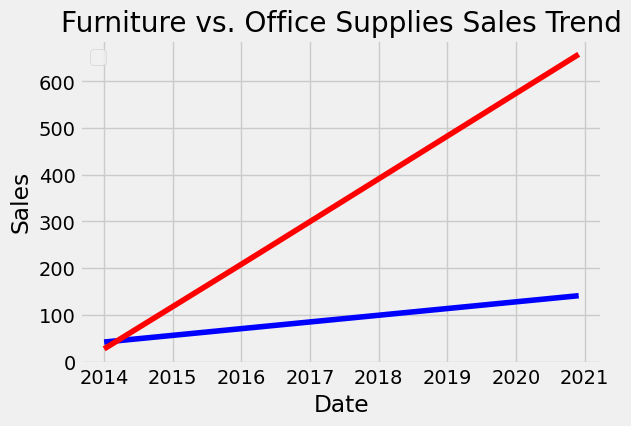

In [61]:
plt.figure(figsize=(6, 4))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend()
plt.xlabel('Date') 
plt.ylabel('Sales')

plt.title('Furniture vs. Office Supplies Sales Trend')
plt.show()

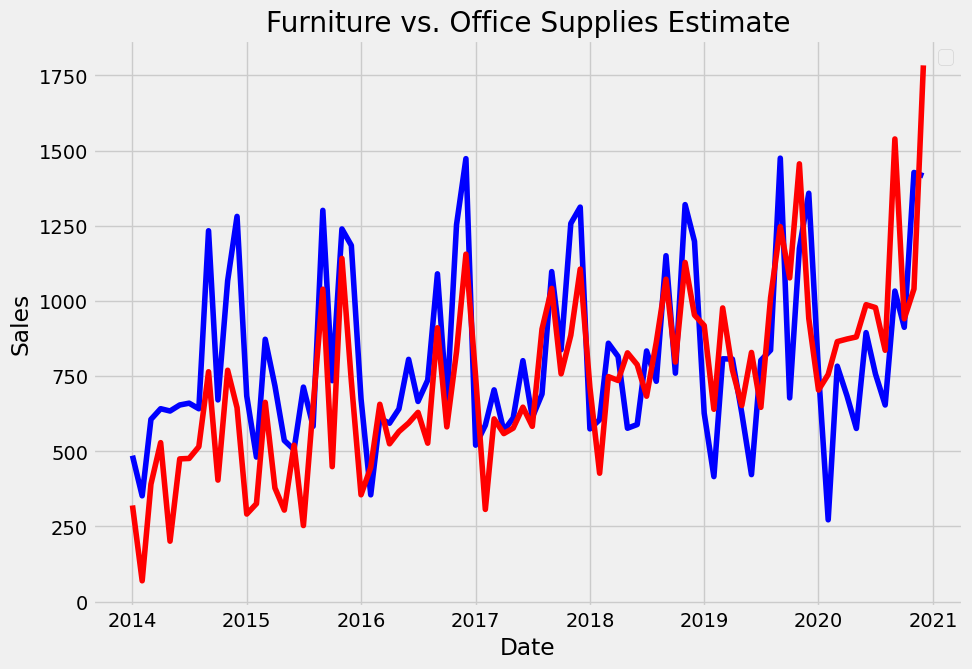

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

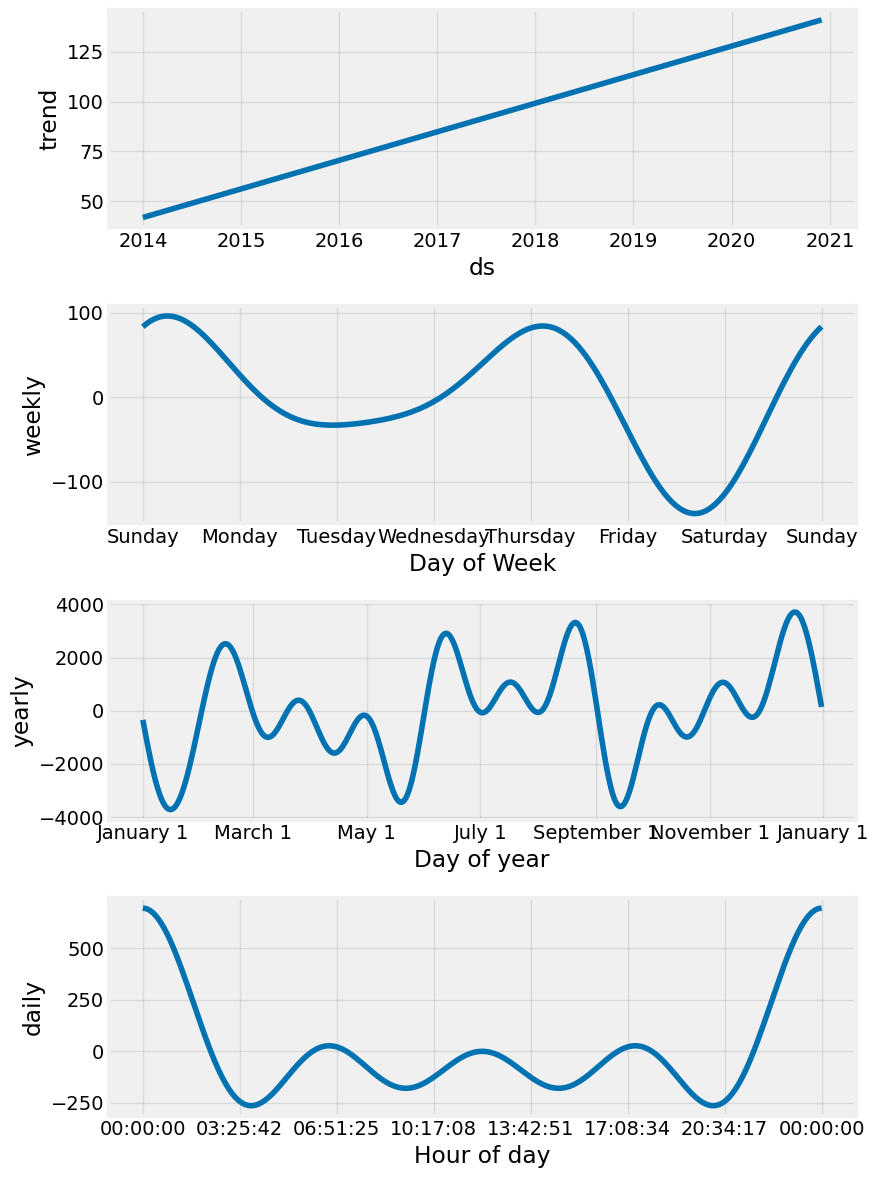

In [63]:
furniture_model.plot_components(furniture_forecast);

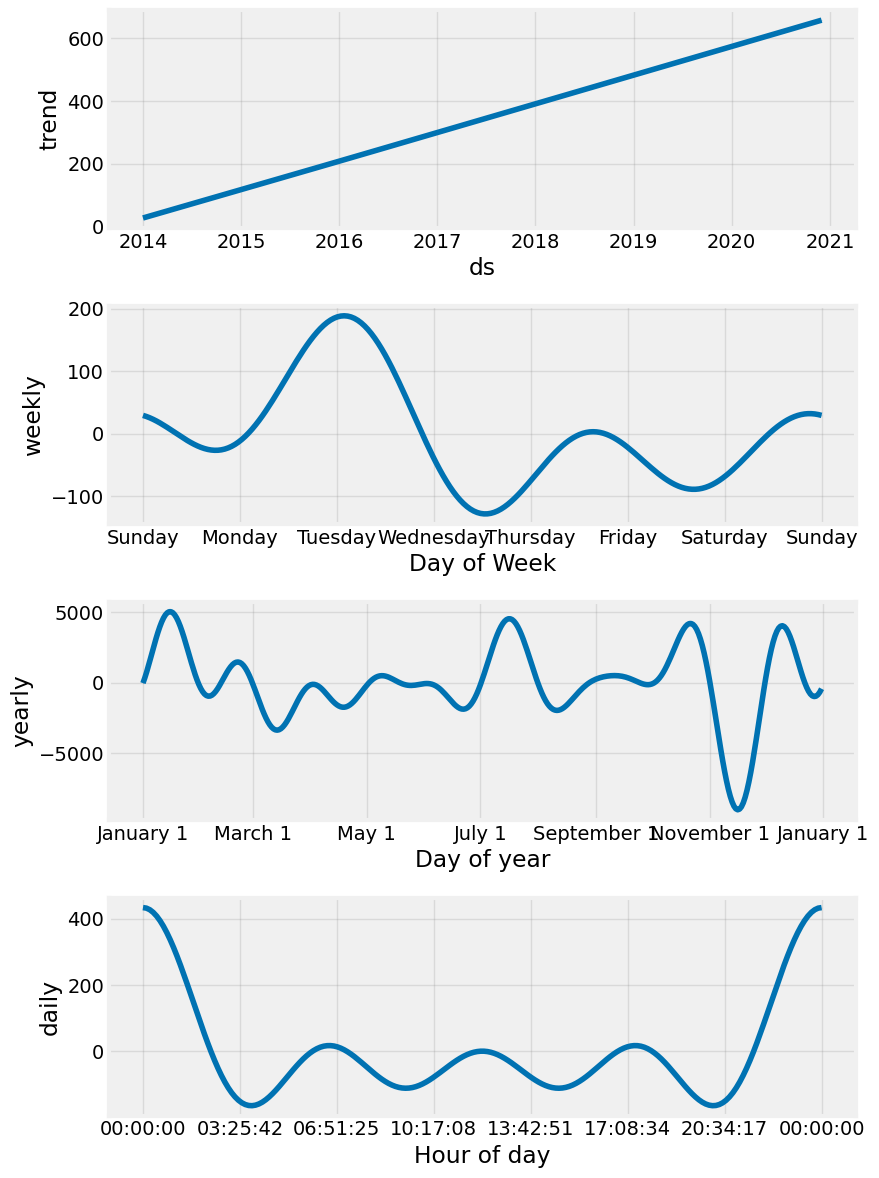

In [64]:
office_model.plot_components(office_forecast);